# Analisis TKDD (Transfer ke Daerah dan Dana Desa) dan IPM di Indonesia Tahun 2023

## Rumusan Masalah
1. Bagaimana tingkat perbandingan antara pagu dan realisasi TKDD di setiap provinsi di Indonesia tahun 2023?
2. Provinsi mana yang memiliki tingkat realisasi tertinggi dan terendah?
3. Apa kemungkinan faktor-faktor yang mempengaruhi tinggi-rendahnya realisasi TKDD?
4. Apakah terdapat hubungan antara realisasi TKDD dan IPM suatu provinsi?
5. Apa saja faktor-faktor yang memengaruhi IPM di tiap provinsi Indonesia pada tahun 2023?

## Metodologi Analisis
- **Exploratory Data Analysis (EDA)**: Pemahaman struktur dan karakteristik data
- **Analisis Persentase Realisasi**: Kategorisasi realisasi TKDD
- **Analisis Korelasi**: Mengidentifikasi hubungan antar variabel
- **ANOVA**: Membandingkan kelompok berdasarkan kategori IPM
- **Visualisasi**: Grafik dan plot untuk insight visual
- **Analisis Regresi**: Mengidentifikasi faktor-faktor prediktif

## 1. Data Preparation dan Exploratory Data Analysis (EDA)

Dataset Shape: (38, 10)

Column Names:
['Provinsi', 'IPM', 'Pagu TKDD', 'Realisasi TKDD', 'Jumlah Penduduk', 'Anggaran APBN per kapita', 'Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto (PDRB) Atas Dasar Harga Berlaku', 'Produk Domestik Regional Bruto per Kapita HB', 'Laju Pertumbuhan PDRB atas dasar konstan 2010']

Numeric columns: 9


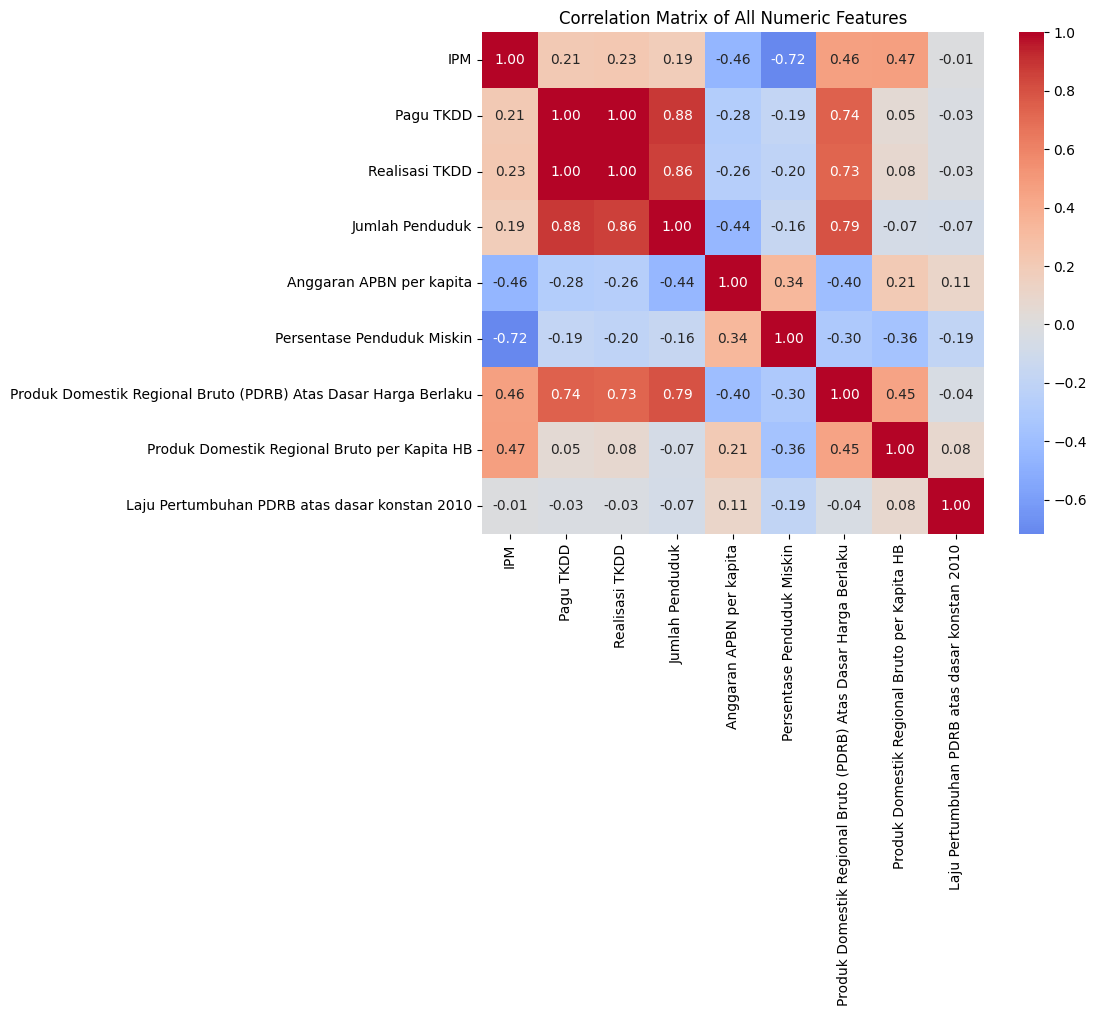


Strong Correlations (|r| > 0.5):
        Variable 1                                         Variable 2  \
1        Pagu TKDD                                     Realisasi TKDD   
2        Pagu TKDD                                    Jumlah Penduduk   
4   Realisasi TKDD                                    Jumlah Penduduk   
6  Jumlah Penduduk  Produk Domestik Regional Bruto (PDRB) Atas Das...   
3        Pagu TKDD  Produk Domestik Regional Bruto (PDRB) Atas Das...   
5   Realisasi TKDD  Produk Domestik Regional Bruto (PDRB) Atas Das...   
0              IPM                         Persentase Penduduk Miskin   

   Correlation Strength  
1     0.998199   Strong  
2     0.883584   Strong  
4     0.860999   Strong  
6     0.794971   Strong  
3     0.741994   Strong  
5     0.731661   Strong  
0    -0.716767   Strong  

ANOVA Results (IPM Categories vs Other Variables):
                                       Variable  F-statistic   p-value  \
0                    Persentase Penduduk Miskin

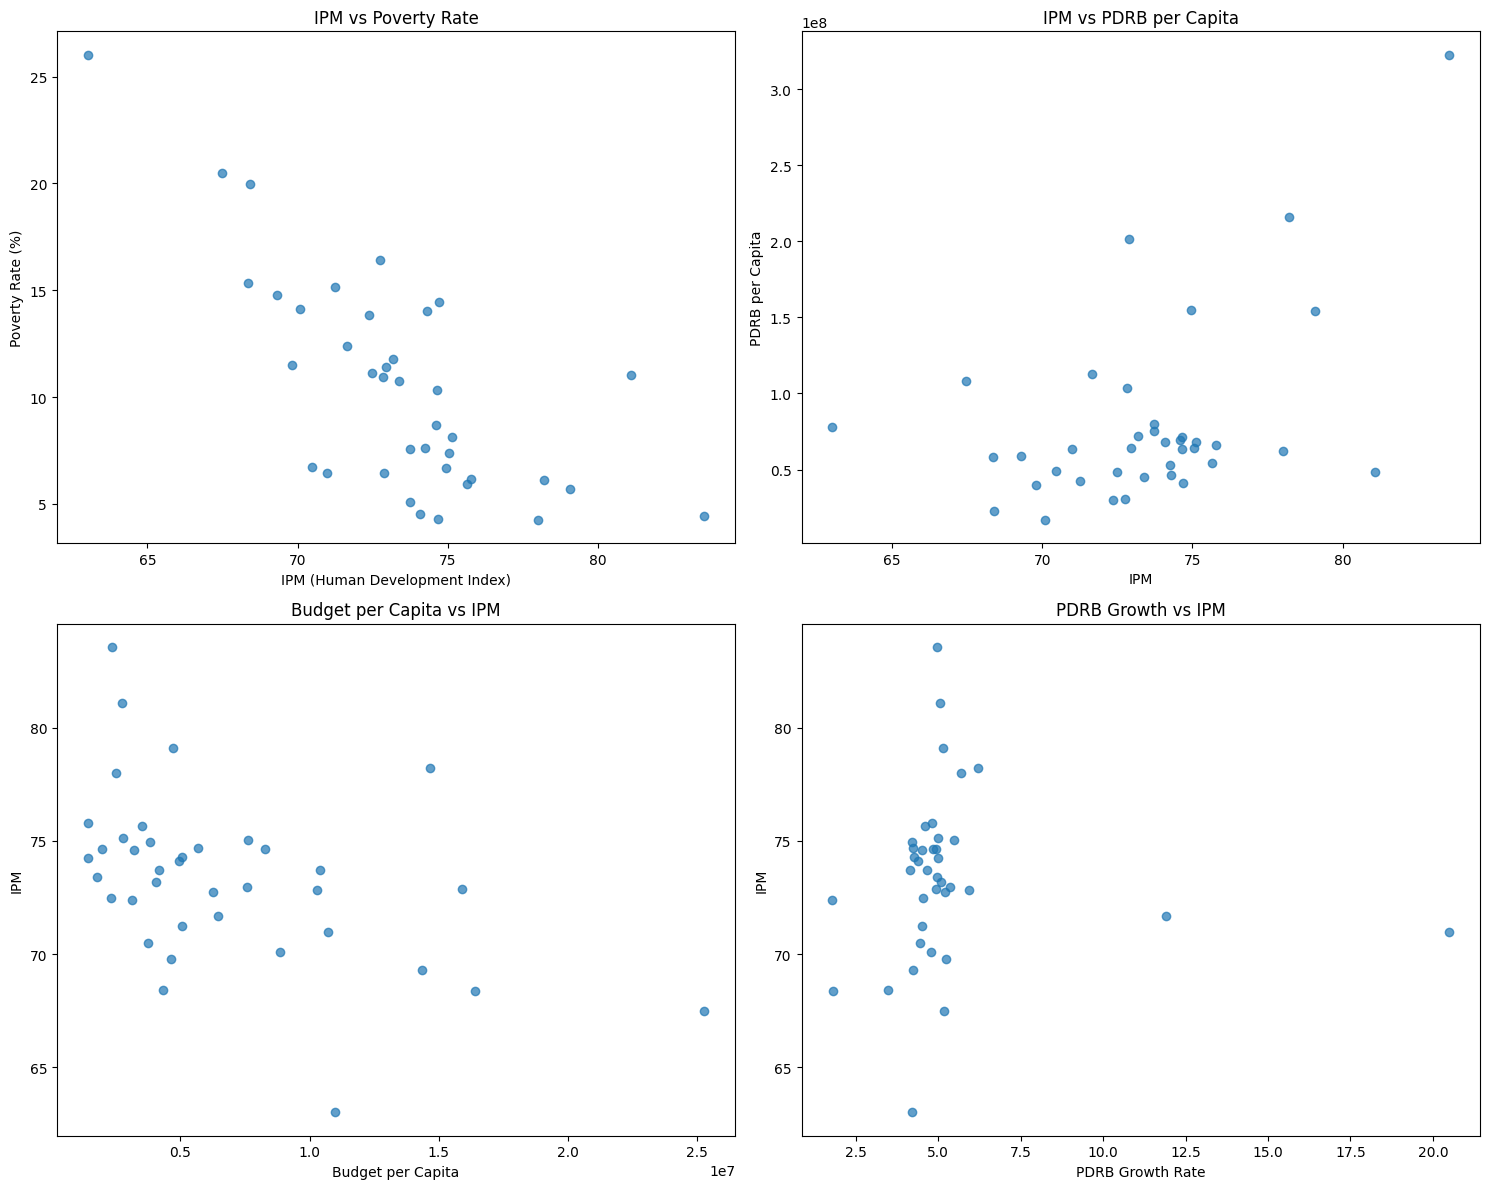

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('dataset_filled_corrected_csv.csv')

# Display basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

# Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {len(numeric_columns)}")

# 1. CORRELATION MATRIX ANALYSIS
correlation_matrix = df[numeric_columns].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of All Numeric Features')
plt.tight_layout()
plt.show()

# 2. STRONG CORRELATIONS (|r| > 0.5)
def find_strong_correlations(corr_matrix, threshold=0.5):
    strong_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                strong_correlations.append({
                    'Variable 1': corr_matrix.columns[i],
                    'Variable 2': corr_matrix.columns[j],
                    'Correlation': corr_value,
                    'Strength': 'Strong' if abs(corr_value) > 0.7 else 'Moderate'
                })
    return pd.DataFrame(strong_correlations)

strong_corr_df = find_strong_correlations(correlation_matrix)
print("\nStrong Correlations (|r| > 0.5):")
print(strong_corr_df.sort_values('Correlation', key=abs, ascending=False))

# 3. ANOVA FOR CATEGORICAL ANALYSIS
# Create categorical groups based on IPM (Human Development Index)
df['IPM_Category'] = pd.cut(df['IPM'], 
                           bins=[0, 70, 75, 80, 100], 
                           labels=['Low', 'Medium', 'High', 'Very High'])

# Perform ANOVA for different variables across IPM categories
anova_results = []
variables_for_anova = ['Persentase Penduduk Miskin', 'Anggaran APBN per kapita', 
                       'Produk Domestik Regional Bruto per Kapita HB']

for var in variables_for_anova:
    groups = [group[var].values for name, group in df.groupby('IPM_Category') if len(group) > 1]
    if len(groups) >= 2:
        f_stat, p_value = f_oneway(*groups)
        anova_results.append({
            'Variable': var,
            'F-statistic': f_stat,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

anova_df = pd.DataFrame(anova_results)
print("\nANOVA Results (IPM Categories vs Other Variables):")
print(anova_df)

# 4. PAIRWISE CORRELATION ANALYSIS
def analyze_specific_correlations(df):
    """Analyze specific meaningful correlations"""
    correlations_of_interest = [
        ('IPM', 'Persentase Penduduk Miskin'),
        ('IPM', 'Produk Domestik Regional Bruto per Kapita HB'),
        ('Anggaran APBN per kapita', 'IPM'),
        ('Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto per Kapita HB'),
        ('Laju Pertumbuhan PDRB atas dasar konstan 2010', 'IPM')
    ]
    
    results = []
    for var1, var2 in correlations_of_interest:
        corr_coef, p_value = pearsonr(df[var1], df[var2])
        results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Correlation': corr_coef,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Interpretation': interpret_correlation(corr_coef)
        })
    
    return pd.DataFrame(results)

def interpret_correlation(r):
    """Interpret correlation strength"""
    abs_r = abs(r)
    if abs_r >= 0.8:
        return "Very Strong"
    elif abs_r >= 0.6:
        return "Strong"
    elif abs_r >= 0.4:
        return "Moderate"
    elif abs_r >= 0.2:
        return "Weak"
    else:
        return "Very Weak"

specific_corr_df = analyze_specific_correlations(df)
print("\nSpecific Correlations of Interest:")
print(specific_corr_df)

# 5. SCATTER PLOTS FOR KEY RELATIONSHIPS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# IPM vs Poverty Rate
axes[0,0].scatter(df['IPM'], df['Persentase Penduduk Miskin'], alpha=0.7)
axes[0,0].set_xlabel('IPM (Human Development Index)')
axes[0,0].set_ylabel('Poverty Rate (%)')
axes[0,0].set_title('IPM vs Poverty Rate')

# IPM vs PDRB per Capita
axes[0,1].scatter(df['IPM'], df['Produk Domestik Regional Bruto per Kapita HB'], alpha=0.7)
axes[0,1].set_xlabel('IPM')
axes[0,1].set_ylabel('PDRB per Capita')
axes[0,1].set_title('IPM vs PDRB per Capita')

# Budget per Capita vs IPM
axes[1,0].scatter(df['Anggaran APBN per kapita'], df['IPM'], alpha=0.7)
axes[1,0].set_xlabel('Budget per Capita')
axes[1,0].set_ylabel('IPM')
axes[1,0].set_title('Budget per Capita vs IPM')

# PDRB Growth vs IPM
axes[1,1].scatter(df['Laju Pertumbuhan PDRB atas dasar konstan 2010'], df['IPM'], alpha=0.7)
axes[1,1].set_xlabel('PDRB Growth Rate')
axes[1,1].set_ylabel('IPM')
axes[1,1].set_title('PDRB Growth vs IPM')

plt.tight_layout()
plt.show()

In [6]:
# Data Quality Check
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check for missing values
print("\n1. MISSING VALUES:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("✅ No missing values found")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n2. DUPLICATE ROWS: {duplicates}")
if duplicates == 0:
    print("✅ No duplicate rows found")

# Basic statistics
print("\n3. BASIC STATISTICS:")
print(df.describe())

# Data types
print("\n4. DATA TYPES:")
print(df.dtypes)

print("\n" + "="*60)
print("EDA FINDINGS:")
print("="*60)
print(f"• Dataset contains {df.shape[0]} provinces and {df.shape[1]} variables")
print(f"• All numeric variables are properly formatted")
print(f"• Data appears to be clean and ready for analysis")

DATA QUALITY ASSESSMENT

1. MISSING VALUES:
Series([], dtype: int64)
✅ No missing values found

2. DUPLICATE ROWS: 0
✅ No duplicate rows found

3. BASIC STATISTICS:
             IPM     Pagu TKDD  Realisasi TKDD  Jumlah Penduduk  \
count  38.000000  3.800000e+01    3.800000e+01     3.800000e+01   
mean   73.388747  2.335268e+13    2.371723e+13     7.334102e+06   
std     3.768384  1.799362e+13    1.828455e+13     1.123341e+07   
min    63.010000  6.172420e+12    6.155410e+12     5.344120e+05   
25%    71.352500  1.139728e+13    1.153712e+13     1.488782e+06   
50%    73.560000  1.860135e+13    1.870740e+13     3.707812e+06   
75%    74.887500  2.694140e+13    2.802720e+13     6.421455e+06   
max    83.550000  8.200830e+13    8.192190e+13     4.985994e+07   

       Anggaran APBN per kapita  Persentase Penduduk Miskin  \
count              3.800000e+01                   38.000000   
mean               6.668411e+06                   10.478173   
std                5.179494e+06           

## 2. Analisis Perbandingan Pagu dan Realisasi TKDD

ANALISIS REALISASI TKDD

1. STATISTIK DESKRIPTIF PERSENTASE REALISASI:
Mean: 101.12%
Median: 100.05%
Std Dev: 3.67%
Min: 94.32%
Max: 110.98%

2. DISTRIBUSI KATEGORI REALISASI:
Diatas 100%: 20 provinsi (52.6%)
90-100%: 18 provinsi (47.4%)

3. PROVINSI DENGAN REALISASI TERTINGGI:
• KALIMANTAN TIMUR: 110.98% (Diatas 100%)
• KALIMANTAN SELATAN: 110.59% (Diatas 100%)
• KEP. RIAU: 109.78% (Diatas 100%)
• KALIMANTAN UTARA: 105.45% (Diatas 100%)
• SUMATERA SELATAN: 104.63% (Diatas 100%)

4. PROVINSI DENGAN REALISASI TERENDAH:
• PAPUA: 94.32% (90-100%)
• PAPUA SELATAN: 94.60% (90-100%)
• PAPUA PEGUNUNGAN: 94.67% (90-100%)
• DI YOGYAKARTA: 98.89% (90-100%)
• SUMATERA BARAT: 99.17% (90-100%)


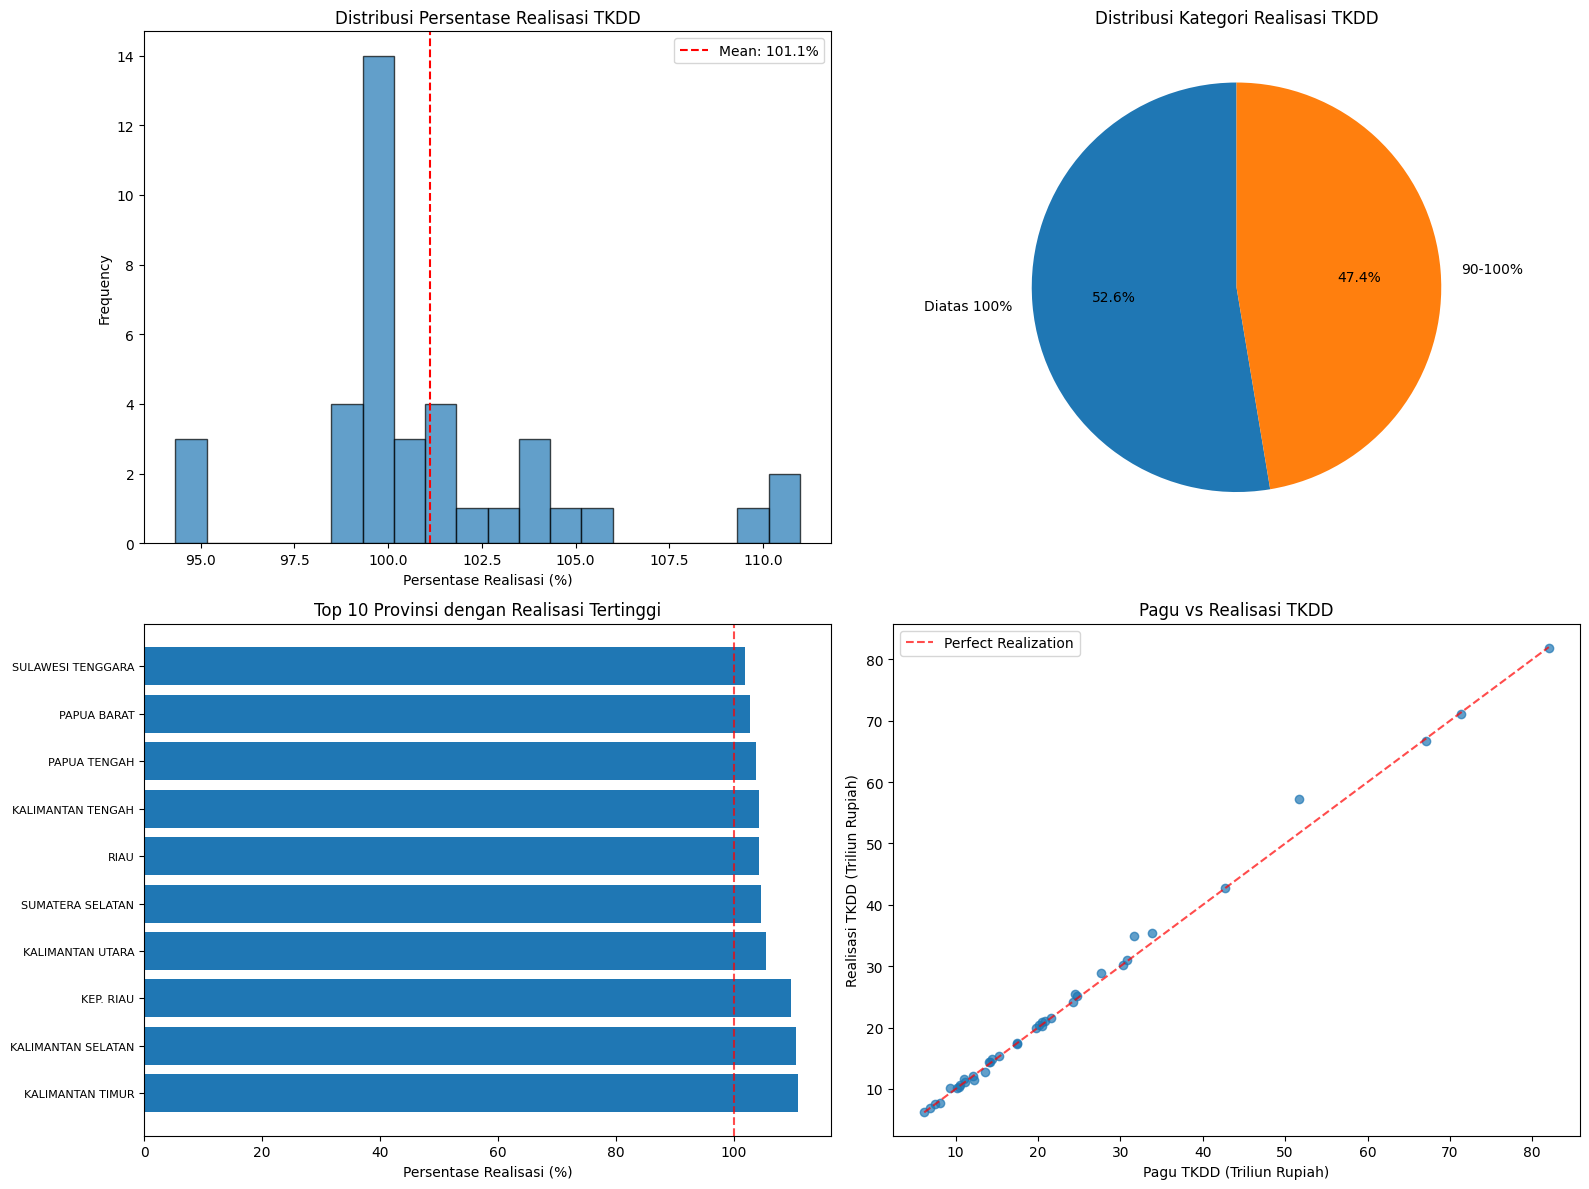


TEMUAN KUNCI:
• Rata-rata realisasi TKDD nasional: 101.12%
• 20 provinsi merealisasikan lebih dari 100%
• 0 provinsi merealisasikan kurang dari 90%
• Range realisasi: 94.32% - 110.98%


In [7]:
# Calculate realization percentage
df['Persentase_Realisasi'] = (df['Realisasi TKDD'] / df['Pagu TKDD']) * 100

# Categorize realization levels
def kategorisasi_realisasi(persentase):
    if persentase < 90:
        return 'Dibawah 90%'
    elif persentase <= 100:
        return '90-100%'
    else:
        return 'Diatas 100%'

df['Kategori_Realisasi'] = df['Persentase_Realisasi'].apply(kategorisasi_realisasi)

print("="*60)
print("ANALISIS REALISASI TKDD")
print("="*60)

# Basic statistics of realization percentage
print("\n1. STATISTIK DESKRIPTIF PERSENTASE REALISASI:")
print(f"Mean: {df['Persentase_Realisasi'].mean():.2f}%")
print(f"Median: {df['Persentase_Realisasi'].median():.2f}%")
print(f"Std Dev: {df['Persentase_Realisasi'].std():.2f}%")
print(f"Min: {df['Persentase_Realisasi'].min():.2f}%")
print(f"Max: {df['Persentase_Realisasi'].max():.2f}%")

# Distribution by category
print("\n2. DISTRIBUSI KATEGORI REALISASI:")
kategori_count = df['Kategori_Realisasi'].value_counts()
for kategori, count in kategori_count.items():
    percentage = (count / len(df)) * 100
    print(f"{kategori}: {count} provinsi ({percentage:.1f}%)")

# Top and bottom performers
print("\n3. PROVINSI DENGAN REALISASI TERTINGGI:")
top_5 = df.nlargest(5, 'Persentase_Realisasi')[['Provinsi', 'Persentase_Realisasi', 'Kategori_Realisasi']]
for idx, row in top_5.iterrows():
    print(f"• {row['Provinsi']}: {row['Persentase_Realisasi']:.2f}% ({row['Kategori_Realisasi']})")

print("\n4. PROVINSI DENGAN REALISASI TERENDAH:")
bottom_5 = df.nsmallest(5, 'Persentase_Realisasi')[['Provinsi', 'Persentase_Realisasi', 'Kategori_Realisasi']]
for idx, row in bottom_5.iterrows():
    print(f"• {row['Provinsi']}: {row['Persentase_Realisasi']:.2f}% ({row['Kategori_Realisasi']})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of realization percentage
axes[0,0].hist(df['Persentase_Realisasi'], bins=20, edgecolor='black', alpha=0.7)
axes[0,0].axvline(df['Persentase_Realisasi'].mean(), color='red', linestyle='--', label=f'Mean: {df["Persentase_Realisasi"].mean():.1f}%')
axes[0,0].set_xlabel('Persentase Realisasi (%)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribusi Persentase Realisasi TKDD')
axes[0,0].legend()

# 2. Category distribution pie chart
axes[0,1].pie(kategori_count.values, labels=kategori_count.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribusi Kategori Realisasi TKDD')

# 3. Bar chart of top 10 provinces
top_10 = df.nlargest(10, 'Persentase_Realisasi')
axes[1,0].barh(range(len(top_10)), top_10['Persentase_Realisasi'])
axes[1,0].set_yticks(range(len(top_10)))
axes[1,0].set_yticklabels(top_10['Provinsi'], fontsize=8)
axes[1,0].set_xlabel('Persentase Realisasi (%)')
axes[1,0].set_title('Top 10 Provinsi dengan Realisasi Tertinggi')
axes[1,0].axvline(100, color='red', linestyle='--', alpha=0.7)

# 4. Scatter plot: Pagu vs Realisasi
axes[1,1].scatter(df['Pagu TKDD']/1e12, df['Realisasi TKDD']/1e12, alpha=0.7)
axes[1,1].plot([df['Pagu TKDD'].min()/1e12, df['Pagu TKDD'].max()/1e12], 
               [df['Pagu TKDD'].min()/1e12, df['Pagu TKDD'].max()/1e12], 
               'r--', alpha=0.7, label='Perfect Realization')
axes[1,1].set_xlabel('Pagu TKDD (Triliun Rupiah)')
axes[1,1].set_ylabel('Realisasi TKDD (Triliun Rupiah)')
axes[1,1].set_title('Pagu vs Realisasi TKDD')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TEMUAN KUNCI:")
print("="*60)
print(f"• Rata-rata realisasi TKDD nasional: {df['Persentase_Realisasi'].mean():.2f}%")
print(f"• {kategori_count.get('Diatas 100%', 0)} provinsi merealisasikan lebih dari 100%")
print(f"• {kategori_count.get('Dibawah 90%', 0)} provinsi merealisasikan kurang dari 90%")
print(f"• Range realisasi: {df['Persentase_Realisasi'].min():.2f}% - {df['Persentase_Realisasi'].max():.2f}%")

## 3. Analisis Faktor-Faktor yang Mempengaruhi Realisasi TKDD

ANALISIS FAKTOR-FAKTOR REALISASI TKDD

1. KORELASI DENGAN PERSENTASE REALISASI:
                                       Faktor  Korelasi  P-value Signifikan Interpretasi
 Produk Domestik Regional Bruto per Kapita HB  0.507724 0.001138         Ya     Moderate
                   Persentase Penduduk Miskin -0.488472 0.001861         Ya     Moderate
                                          IPM  0.411468 0.010272         Ya     Moderate
                     Anggaran APBN per kapita  0.177058 0.287588      Tidak    Very Weak
                              Jumlah Penduduk -0.097320 0.561064      Tidak    Very Weak
Laju Pertumbuhan PDRB atas dasar konstan 2010  0.072474 0.665447      Tidak    Very Weak

2. ANALISIS BERDASARKAN KATEGORI REALISASI:

Diatas 100%:
  • Jumlah provinsi: 20
  • Rata-rata IPM: 74.17
  • Rata-rata tingkat kemiskinan: 8.69%
  • Rata-rata PDRB per kapita: Rp 106419 ribu

90-100%:
  • Jumlah provinsi: 18
  • Rata-rata IPM: 72.52
  • Rata-rata tingkat kemiskinan: 12.46%
  •

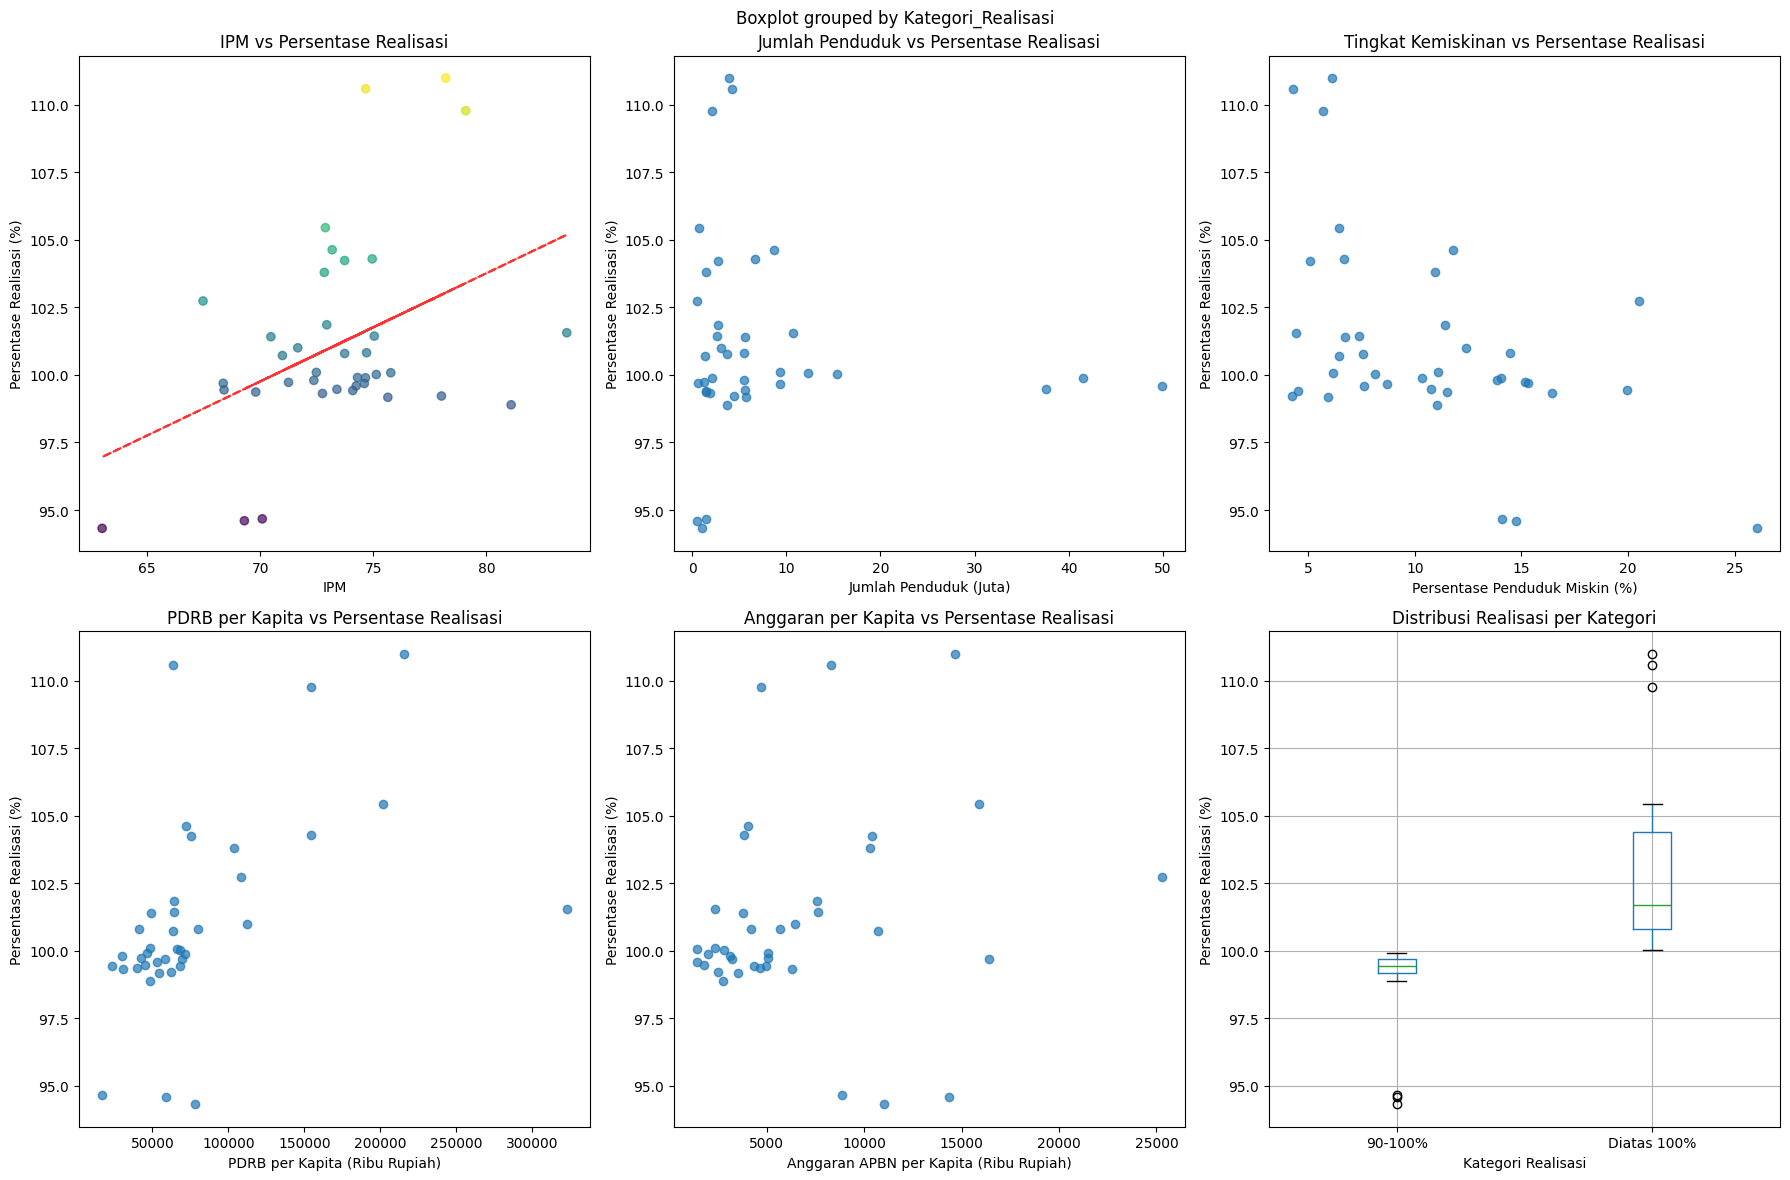


TEMUAN FAKTOR-FAKTOR REALISASI:
• Faktor dengan korelasi terkuat: Produk Domestik Regional Bruto per Kapita HB (r=0.508)
• Jumlah faktor signifikan: 3
• Faktor signifikan:
  - IPM: r=0.411 (Moderate)
  - Persentase Penduduk Miskin: r=-0.488 (Moderate)
  - Produk Domestik Regional Bruto per Kapita HB: r=0.508 (Moderate)


In [8]:
# Analyze factors affecting TKDD realization
print("="*60)
print("ANALISIS FAKTOR-FAKTOR REALISASI TKDD")
print("="*60)

# Correlation analysis with realization percentage
factors = ['IPM', 'Jumlah Penduduk', 'Anggaran APBN per kapita', 
           'Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto per Kapita HB',
           'Laju Pertumbuhan PDRB atas dasar konstan 2010']

print("\n1. KORELASI DENGAN PERSENTASE REALISASI:")
correlations = []
for factor in factors:
    corr_coef, p_value = pearsonr(df[factor], df['Persentase_Realisasi'])
    correlations.append({
        'Faktor': factor,
        'Korelasi': corr_coef,
        'P-value': p_value,
        'Signifikan': 'Ya' if p_value < 0.05 else 'Tidak',
        'Interpretasi': interpret_correlation(corr_coef)
    })

corr_df = pd.DataFrame(correlations)
corr_df_sorted = corr_df.sort_values('Korelasi', key=abs, ascending=False)
print(corr_df_sorted.to_string(index=False))

# Group analysis by realization category
print("\n2. ANALISIS BERDASARKAN KATEGORI REALISASI:")
for kategori in df['Kategori_Realisasi'].unique():
    print(f"\n{kategori}:")
    subset = df[df['Kategori_Realisasi'] == kategori]
    print(f"  • Jumlah provinsi: {len(subset)}")
    print(f"  • Rata-rata IPM: {subset['IPM'].mean():.2f}")
    print(f"  • Rata-rata tingkat kemiskinan: {subset['Persentase Penduduk Miskin'].mean():.2f}%")
    print(f"  • Rata-rata PDRB per kapita: Rp {subset['Produk Domestik Regional Bruto per Kapita HB'].mean()/1000:.0f} ribu")

# ANOVA analysis for categorical differences
print("\n3. UJI ANOVA ANTAR KATEGORI REALISASI:")
anova_vars = ['IPM', 'Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto per Kapita HB']
anova_results_realisasi = []

for var in anova_vars:
    groups = [group[var].values for name, group in df.groupby('Kategori_Realisasi')]
    f_stat, p_value = f_oneway(*groups)
    anova_results_realisasi.append({
        'Variabel': var,
        'F-statistic': f_stat,
        'p-value': p_value,
        'Signifikan': 'Ya' if p_value < 0.05 else 'Tidak'
    })

anova_realisasi_df = pd.DataFrame(anova_results_realisasi)
print(anova_realisasi_df.to_string(index=False))

# Visualization of key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. IPM vs Realization
axes[0,0].scatter(df['IPM'], df['Persentase_Realisasi'], alpha=0.7, c=df['Persentase_Realisasi'], cmap='viridis')
axes[0,0].set_xlabel('IPM')
axes[0,0].set_ylabel('Persentase Realisasi (%)')
axes[0,0].set_title('IPM vs Persentase Realisasi')
z = np.polyfit(df['IPM'], df['Persentase_Realisasi'], 1)
p = np.poly1d(z)
axes[0,0].plot(df['IPM'], p(df['IPM']), "r--", alpha=0.8)

# 2. Population vs Realization
axes[0,1].scatter(df['Jumlah Penduduk']/1000000, df['Persentase_Realisasi'], alpha=0.7)
axes[0,1].set_xlabel('Jumlah Penduduk (Juta)')
axes[0,1].set_ylabel('Persentase Realisasi (%)')
axes[0,1].set_title('Jumlah Penduduk vs Persentase Realisasi')

# 3. Poverty rate vs Realization
axes[0,2].scatter(df['Persentase Penduduk Miskin'], df['Persentase_Realisasi'], alpha=0.7)
axes[0,2].set_xlabel('Persentase Penduduk Miskin (%)')
axes[0,2].set_ylabel('Persentase Realisasi (%)')
axes[0,2].set_title('Tingkat Kemiskinan vs Persentase Realisasi')

# 4. PDRB per capita vs Realization
axes[1,0].scatter(df['Produk Domestik Regional Bruto per Kapita HB']/1000, df['Persentase_Realisasi'], alpha=0.7)
axes[1,0].set_xlabel('PDRB per Kapita (Ribu Rupiah)')
axes[1,0].set_ylabel('Persentase Realisasi (%)')
axes[1,0].set_title('PDRB per Kapita vs Persentase Realisasi')

# 5. Budget per capita vs Realization
axes[1,1].scatter(df['Anggaran APBN per kapita']/1000, df['Persentase_Realisasi'], alpha=0.7)
axes[1,1].set_xlabel('Anggaran APBN per Kapita (Ribu Rupiah)')
axes[1,1].set_ylabel('Persentase Realisasi (%)')
axes[1,1].set_title('Anggaran per Kapita vs Persentase Realisasi')

# 6. Box plot by category
df.boxplot(column='Persentase_Realisasi', by='Kategori_Realisasi', ax=axes[1,2])
axes[1,2].set_xlabel('Kategori Realisasi')
axes[1,2].set_ylabel('Persentase Realisasi (%)')
axes[1,2].set_title('Distribusi Realisasi per Kategori')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TEMUAN FAKTOR-FAKTOR REALISASI:")
print("="*60)
strongest_corr = corr_df_sorted.iloc[0]
print(f"• Faktor dengan korelasi terkuat: {strongest_corr['Faktor']} (r={strongest_corr['Korelasi']:.3f})")
significant_factors = corr_df[corr_df['Signifikan'] == 'Ya']
print(f"• Jumlah faktor signifikan: {len(significant_factors)}")
if len(significant_factors) > 0:
    print("• Faktor signifikan:")
    for _, row in significant_factors.iterrows():
        print(f"  - {row['Faktor']}: r={row['Korelasi']:.3f} ({row['Interpretasi']})")

## 4. Analisis Hubungan Realisasi TKDD dengan IPM

ANALISIS HUBUNGAN REALISASI TKDD DAN IPM

1. KORELASI LANGSUNG:
   Korelasi Persentase Realisasi TKDD vs IPM: 0.4115
   P-value: 0.010272
   Signifikan: Ya
   Interpretasi: Moderate

2. ANALISIS BERDASARKAN KUARTIL IPM:

   Q3 (Sedang-Tinggi):
   • Range IPM: 73.73 - 74.70
   • Jumlah provinsi: 9
   • Rata-rata realisasi TKDD: 101.66%
   • Standar deviasi realisasi: 3.66%
   • Provinsi dengan realisasi >100%: 4

   Q4 (Tinggi):
   • Range IPM: 74.95 - 83.55
   • Jumlah provinsi: 10
   • Rata-rata realisasi TKDD: 102.54%
   • Standar deviasi realisasi: 4.43%
   • Provinsi dengan realisasi >100%: 7

   Q1 (Rendah):
   • Range IPM: 63.01 - 71.25
   • Jumlah provinsi: 10
   • Rata-rata realisasi TKDD: 98.67%
   • Standar deviasi realisasi: 3.03%
   • Provinsi dengan realisasi >100%: 3

   Q2 (Sedang-Rendah):
   • Range IPM: 71.66 - 73.39
   • Jumlah provinsi: 9
   • Rata-rata realisasi TKDD: 101.71%
   • Standar deviasi realisasi: 2.36%
   • Provinsi dengan realisasi >100%: 6

3. ANALISIS 

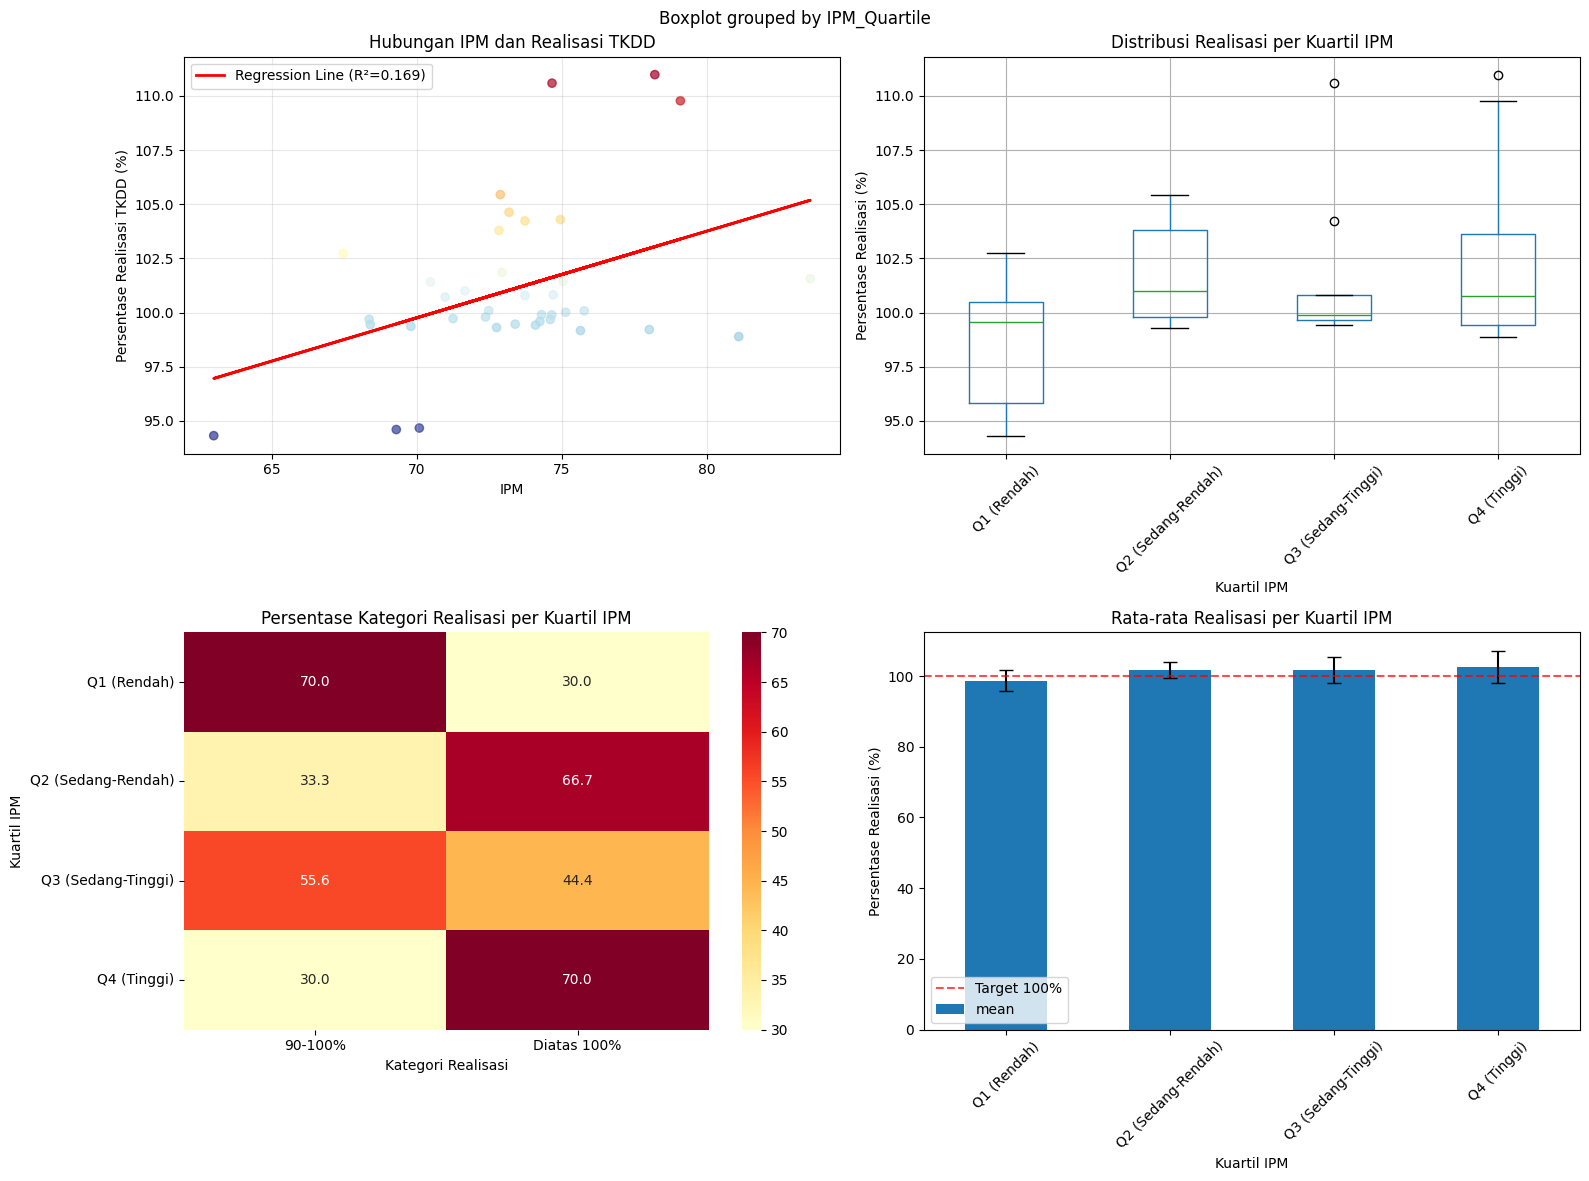


6. ANALISIS OUTLIER DAN KASUS KHUSUS:

TEMUAN HUBUNGAN TKDD-IPM:
• Korelasi TKDD-IPM: 0.4115 (Moderate)
• IPM menjelaskan 16.93% variasi realisasi TKDD
• Perbedaan signifikan antar kuartil IPM: Tidak


In [9]:
# Detailed analysis of TKDD realization and IPM relationship
print("="*60)
print("ANALISIS HUBUNGAN REALISASI TKDD DAN IPM")
print("="*60)

# Direct correlation analysis
corr_tkdd_ipm, p_val_tkdd_ipm = pearsonr(df['Persentase_Realisasi'], df['IPM'])
print(f"\n1. KORELASI LANGSUNG:")
print(f"   Korelasi Persentase Realisasi TKDD vs IPM: {corr_tkdd_ipm:.4f}")
print(f"   P-value: {p_val_tkdd_ipm:.6f}")
print(f"   Signifikan: {'Ya' if p_val_tkdd_ipm < 0.05 else 'Tidak'}")
print(f"   Interpretasi: {interpret_correlation(corr_tkdd_ipm)}")

# Create IPM quartiles for detailed analysis
df['IPM_Quartile'] = pd.qcut(df['IPM'], q=4, labels=['Q1 (Rendah)', 'Q2 (Sedang-Rendah)', 'Q3 (Sedang-Tinggi)', 'Q4 (Tinggi)'])

print(f"\n2. ANALISIS BERDASARKAN KUARTIL IPM:")
for quartile in df['IPM_Quartile'].unique():
    subset = df[df['IPM_Quartile'] == quartile]
    print(f"\n   {quartile}:")
    print(f"   • Range IPM: {subset['IPM'].min():.2f} - {subset['IPM'].max():.2f}")
    print(f"   • Jumlah provinsi: {len(subset)}")
    print(f"   • Rata-rata realisasi TKDD: {subset['Persentase_Realisasi'].mean():.2f}%")
    print(f"   • Standar deviasi realisasi: {subset['Persentase_Realisasi'].std():.2f}%")
    print(f"   • Provinsi dengan realisasi >100%: {len(subset[subset['Persentase_Realisasi'] > 100])}")

# Regression analysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df[['IPM']].values
y = df['Persentase_Realisasi'].values

reg_model = LinearRegression()
reg_model.fit(X, y)
y_pred = reg_model.predict(X)
r2 = r2_score(y, y_pred)

print(f"\n3. ANALISIS REGRESI LINEAR:")
print(f"   Persamaan: Realisasi = {reg_model.coef_[0]:.4f} * IPM + {reg_model.intercept_:.4f}")
print(f"   R-squared: {r2:.4f}")
print(f"   Interpretasi: IPM menjelaskan {r2*100:.2f}% variasi dalam realisasi TKDD")

# ANOVA test across IPM quartiles
groups_ipm = [group['Persentase_Realisasi'].values for name, group in df.groupby('IPM_Quartile')]
f_stat_ipm, p_val_ipm = f_oneway(*groups_ipm)

print(f"\n4. UJI ANOVA ANTAR KUARTIL IPM:")
print(f"   F-statistic: {f_stat_ipm:.4f}")
print(f"   P-value: {p_val_ipm:.6f}")
print(f"   Signifikan: {'Ya' if p_val_ipm < 0.05 else 'Tidak'}")

# Cross-tabulation analysis
cross_tab = pd.crosstab(df['IPM_Quartile'], df['Kategori_Realisasi'], margins=True)
print(f"\n5. TABULASI SILANG IPM QUARTILE vs KATEGORI REALISASI:")
print(cross_tab)

# Detailed visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot with regression line
axes[0,0].scatter(df['IPM'], df['Persentase_Realisasi'], alpha=0.7, c=df['Persentase_Realisasi'], cmap='RdYlBu_r')
axes[0,0].plot(df['IPM'], y_pred, 'r-', linewidth=2, label=f'Regression Line (R²={r2:.3f})')
axes[0,0].set_xlabel('IPM')
axes[0,0].set_ylabel('Persentase Realisasi TKDD (%)')
axes[0,0].set_title('Hubungan IPM dan Realisasi TKDD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Box plot by IPM quartiles
df.boxplot(column='Persentase_Realisasi', by='IPM_Quartile', ax=axes[0,1])
axes[0,1].set_xlabel('Kuartil IPM')
axes[0,1].set_ylabel('Persentase Realisasi (%)')
axes[0,1].set_title('Distribusi Realisasi per Kuartil IPM')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Heatmap of cross-tabulation
cross_tab_pct = pd.crosstab(df['IPM_Quartile'], df['Kategori_Realisasi'], normalize='index') * 100
sns.heatmap(cross_tab_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,0])
axes[1,0].set_title('Persentase Kategori Realisasi per Kuartil IPM')
axes[1,0].set_ylabel('Kuartil IPM')
axes[1,0].set_xlabel('Kategori Realisasi')

# 4. Mean realization by IPM quartile
quartile_means = df.groupby('IPM_Quartile')['Persentase_Realisasi'].agg(['mean', 'std'])
quartile_means['mean'].plot(kind='bar', yerr=quartile_means['std'], ax=axes[1,1], capsize=5)
axes[1,1].set_title('Rata-rata Realisasi per Kuartil IPM')
axes[1,1].set_ylabel('Persentase Realisasi (%)')
axes[1,1].set_xlabel('Kuartil IPM')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Target 100%')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Identify outliers and special cases
print(f"\n6. ANALISIS OUTLIER DAN KASUS KHUSUS:")

# High IPM but low realization
high_ipm_low_real = df[(df['IPM'] > df['IPM'].quantile(0.75)) & (df['Persentase_Realisasi'] < 95)]
if len(high_ipm_low_real) > 0:
    print(f"\n   Provinsi IPM Tinggi tapi Realisasi Rendah:")
    for idx, row in high_ipm_low_real.iterrows():
        print(f"   • {row['Provinsi']}: IPM={row['IPM']:.2f}, Realisasi={row['Persentase_Realisasi']:.2f}%")

# Low IPM but high realization
low_ipm_high_real = df[(df['IPM'] < df['IPM'].quantile(0.25)) & (df['Persentase_Realisasi'] > 105)]
if len(low_ipm_high_real) > 0:
    print(f"\n   Provinsi IPM Rendah tapi Realisasi Tinggi:")
    for idx, row in low_ipm_high_real.iterrows():
        print(f"   • {row['Provinsi']}: IPM={row['IPM']:.2f}, Realisasi={row['Persentase_Realisasi']:.2f}%")

print(f"\n" + "="*60)
print("TEMUAN HUBUNGAN TKDD-IPM:")
print("="*60)
print(f"• Korelasi TKDD-IPM: {corr_tkdd_ipm:.4f} ({interpret_correlation(corr_tkdd_ipm)})")
print(f"• IPM menjelaskan {r2*100:.2f}% variasi realisasi TKDD")
print(f"• Perbedaan signifikan antar kuartil IPM: {'Ya' if p_val_ipm < 0.05 else 'Tidak'}")
if len(high_ipm_low_real) > 0:
    print(f"• Terdapat {len(high_ipm_low_real)} provinsi dengan IPM tinggi namun realisasi rendah")
if len(low_ipm_high_real) > 0:
    print(f"• Terdapat {len(low_ipm_high_real)} provinsi dengan IPM rendah namun realisasi tinggi")

## 5. Analisis Faktor-Faktor yang Mempengaruhi IPM

ANALISIS FAKTOR-FAKTOR YANG MEMPENGARUHI IPM

1. KORELASI DENGAN IPM:
                                       Faktor  Korelasi      P-value Signifikan Interpretasi
                   Persentase Penduduk Miskin -0.716767 4.154771e-07         Ya       Strong
 Produk Domestik Regional Bruto per Kapita HB  0.470777 2.854546e-03         Ya     Moderate
                     Anggaran APBN per kapita -0.458493 3.791677e-03         Ya     Moderate
                               Realisasi TKDD  0.225619 1.732025e-01      Tidak         Weak
                                    Pagu TKDD  0.209738 2.062885e-01      Tidak         Weak
                              Jumlah Penduduk  0.186337 2.626566e-01      Tidak    Very Weak
Laju Pertumbuhan PDRB atas dasar konstan 2010 -0.012162 9.422264e-01      Tidak    Very Weak

2. ANALISIS REGRESI MULTIPEL IPM:
   R-squared: 0.6908
   Interpretasi: 69.08% variasi IPM dijelaskan oleh faktor-faktor ekonomi

   Koefisien Regresi (Standardized):
   • Persentase Pe

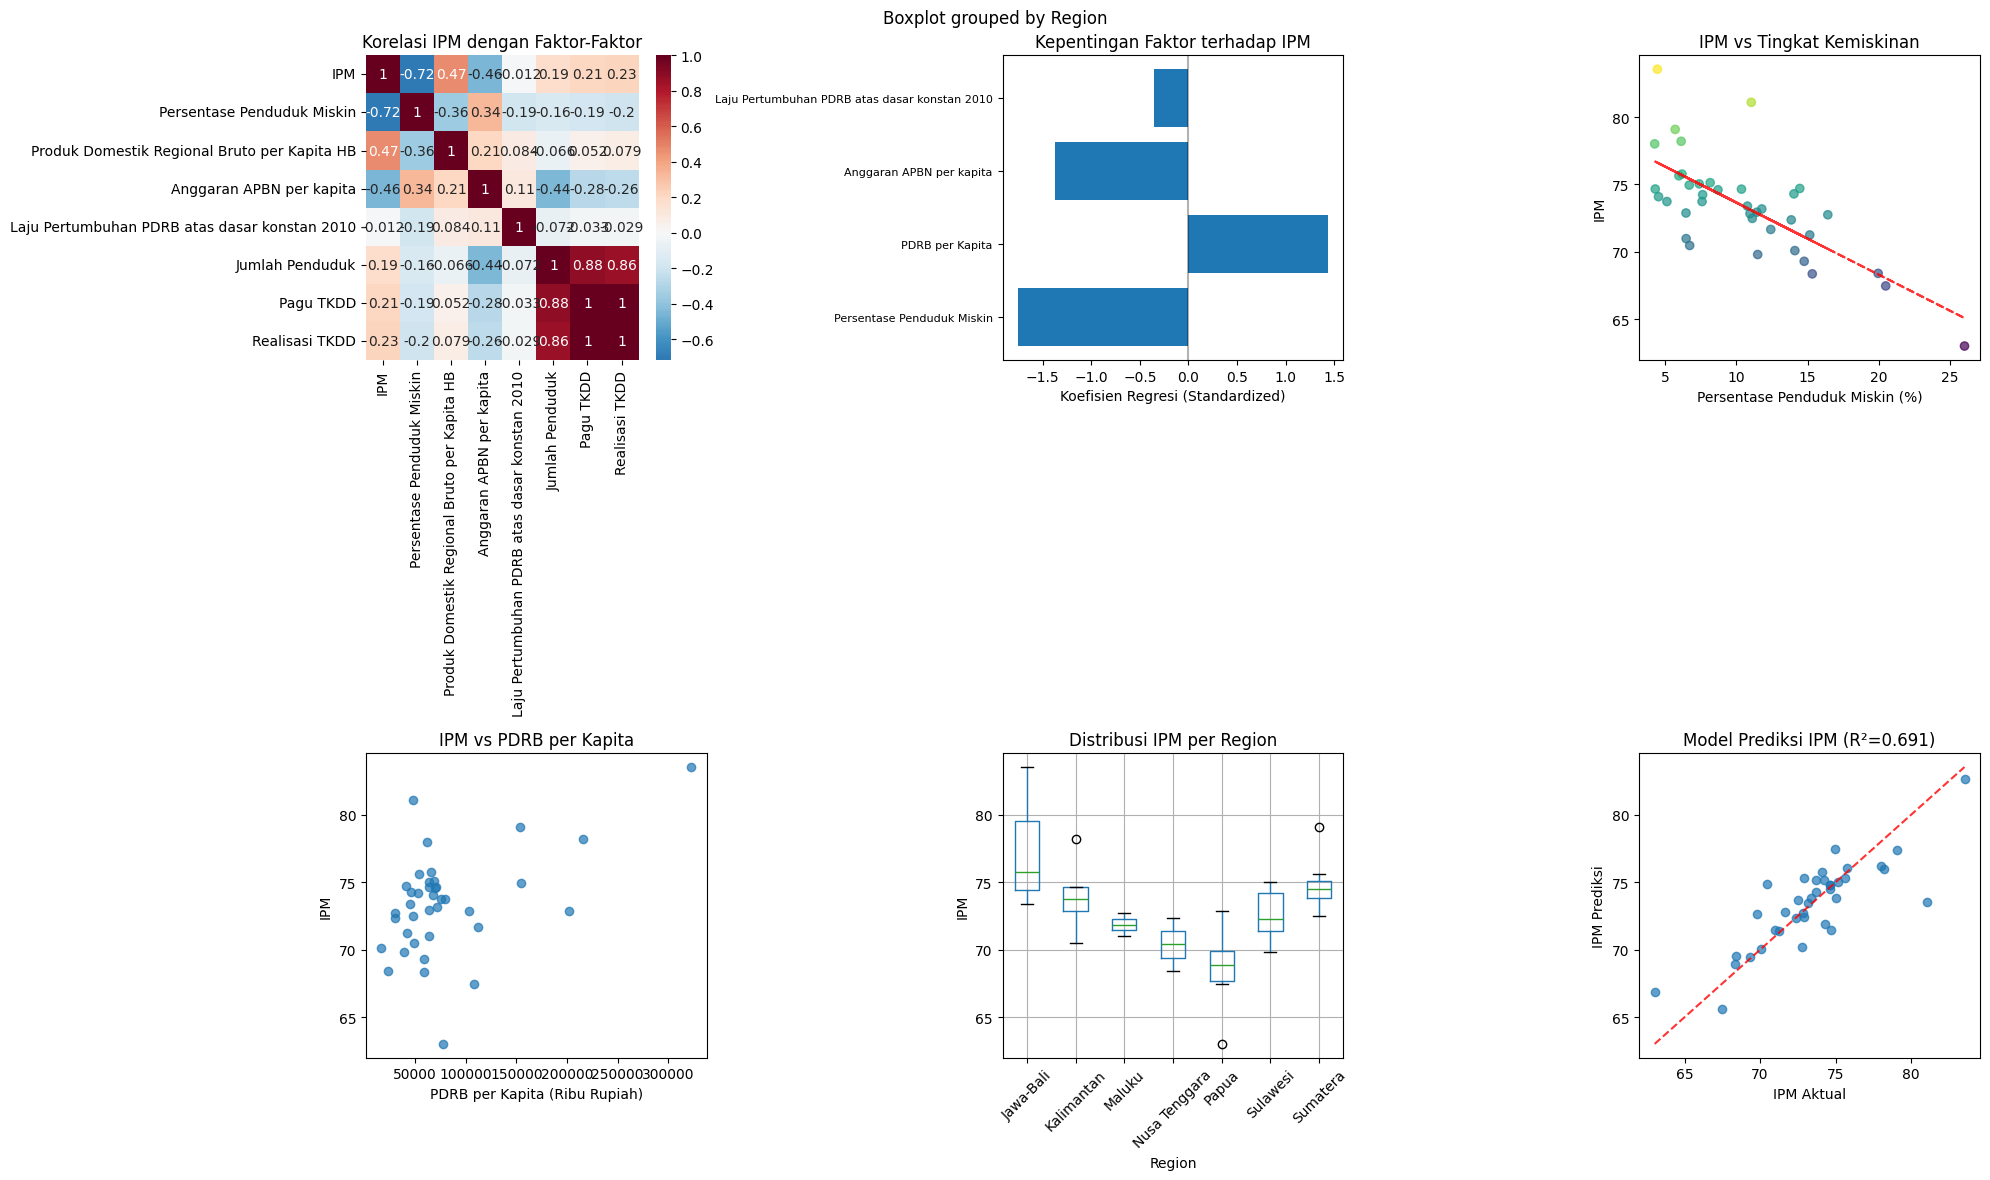


TEMUAN FAKTOR-FAKTOR IPM:
• Faktor dengan korelasi terkuat: Persentase Penduduk Miskin (r=-0.717)
• Jumlah faktor signifikan: 3
• Model regresi menjelaskan 69.08% variasi IPM
• Perbedaan regional signifikan: Ya
• Region dengan IPM tertinggi: Jawa-Bali
• Region dengan IPM terendah: Papua


In [10]:
# Comprehensive analysis of factors affecting IPM
print("="*60)
print("ANALISIS FAKTOR-FAKTOR YANG MEMPENGARUHI IPM")
print("="*60)

# Correlation analysis with IPM
ipm_factors = ['Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto per Kapita HB',
               'Anggaran APBN per kapita', 'Laju Pertumbuhan PDRB atas dasar konstan 2010',
               'Jumlah Penduduk', 'Pagu TKDD', 'Realisasi TKDD']

print("\n1. KORELASI DENGAN IPM:")
ipm_correlations = []
for factor in ipm_factors:
    corr_coef, p_value = pearsonr(df[factor], df['IPM'])
    ipm_correlations.append({
        'Faktor': factor,
        'Korelasi': corr_coef,
        'P-value': p_value,
        'Signifikan': 'Ya' if p_value < 0.05 else 'Tidak',
        'Interpretasi': interpret_correlation(corr_coef)
    })

ipm_corr_df = pd.DataFrame(ipm_correlations)
ipm_corr_df_sorted = ipm_corr_df.sort_values('Korelasi', key=abs, ascending=False)
print(ipm_corr_df_sorted.to_string(index=False))

# Multiple regression analysis for IPM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features for multiple regression
feature_cols = ['Persentase Penduduk Miskin', 'Produk Domestik Regional Bruto per Kapita HB',
                'Anggaran APBN per kapita', 'Laju Pertumbuhan PDRB atas dasar konstan 2010']

X_multi = df[feature_cols].values
y_ipm = df['IPM'].values

# Standardize features
scaler = StandardScaler()
X_multi_scaled = scaler.fit_transform(X_multi)

# Multiple regression
reg_multi = LinearRegression()
reg_multi.fit(X_multi_scaled, y_ipm)
y_ipm_pred = reg_multi.predict(X_multi_scaled)
r2_multi = r2_score(y_ipm, y_ipm_pred)

print(f"\n2. ANALISIS REGRESI MULTIPEL IPM:")
print(f"   R-squared: {r2_multi:.4f}")
print(f"   Interpretasi: {r2_multi*100:.2f}% variasi IPM dijelaskan oleh faktor-faktor ekonomi")
print(f"\n   Koefisien Regresi (Standardized):")
for i, feature in enumerate(feature_cols):
    print(f"   • {feature}: {reg_multi.coef_[i]:.4f}")

# Identify most important factors
feature_importance = pd.DataFrame({
    'Faktor': feature_cols,
    'Koefisien': reg_multi.coef_,
    'Abs_Koefisien': np.abs(reg_multi.coef_)
}).sort_values('Abs_Koefisien', ascending=False)

print(f"\n3. URUTAN KEPENTINGAN FAKTOR (berdasarkan koefisien regresi):")
for idx, row in feature_importance.iterrows():
    direction = "positif" if row['Koefisien'] > 0 else "negatif"
    print(f"   {idx+1}. {row['Faktor']}: {row['Koefisien']:.4f} (pengaruh {direction})")

# Regional analysis
# Create regional groupings
def get_region(provinsi):
    sumatera = ['ACEH', 'SUMATERA UTARA', 'SUMATERA BARAT', 'RIAU', 'JAMBI', 
                'SUMATERA SELATAN', 'BENGKULU', 'LAMPUNG', 'KEP. BANGKA BELITUNG', 'KEP. RIAU']
    jawa = ['DKI JAKARTA', 'JAWA BARAT', 'JAWA TENGAH', 'DI YOGYAKARTA', 'JAWA TIMUR', 'BANTEN']
    kalimantan = ['KALIMANTAN BARAT', 'KALIMANTAN TENGAH', 'KALIMANTAN SELATAN', 
                  'KALIMANTAN TIMUR', 'KALIMANTAN UTARA']
    sulawesi = ['SULAWESI UTARA', 'SULAWESI TENGAH', 'SULAWESI SELATAN', 
                'SULAWESI TENGGARA', 'GORONTALO', 'SULAWESI BARAT']
    
    if provinsi in sumatera:
        return 'Sumatera'
    elif provinsi in jawa:
        return 'Jawa-Bali'
    elif provinsi in kalimantan:
        return 'Kalimantan'
    elif provinsi in sulawesi:
        return 'Sulawesi'
    elif 'PAPUA' in provinsi:
        return 'Papua'
    elif 'NUSA TENGGARA' in provinsi:
        return 'Nusa Tenggara'
    elif provinsi == 'BALI':
        return 'Jawa-Bali'
    elif 'MALUKU' in provinsi:
        return 'Maluku'
    else:
        return 'Lainnya'

df['Region'] = df['Provinsi'].apply(get_region)

print(f"\n4. ANALISIS REGIONAL IPM:")
regional_stats = df.groupby('Region').agg({
    'IPM': ['mean', 'std', 'min', 'max'],
    'Persentase Penduduk Miskin': 'mean',
    'Produk Domestik Regional Bruto per Kapita HB': 'mean'
}).round(2)

print(regional_stats)

# ANOVA across regions
regions_ipm = [group['IPM'].values for name, group in df.groupby('Region') if len(group) > 2]
f_stat_region, p_val_region = f_oneway(*regions_ipm)

print(f"\n5. UJI ANOVA ANTAR REGION:")
print(f"   F-statistic: {f_stat_region:.4f}")
print(f"   P-value: {p_val_region:.6f}")
print(f"   Signifikan: {'Ya' if p_val_region < 0.05 else 'Tidak'}")

# Comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Correlation heatmap for IPM factors
ipm_corr_matrix = df[['IPM'] + ipm_factors].corr()
sns.heatmap(ipm_corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=axes[0,0])
axes[0,0].set_title('Korelasi IPM dengan Faktor-Faktor')

# 2. Feature importance bar chart
axes[0,1].barh(range(len(feature_importance)), feature_importance['Koefisien'])
axes[0,1].set_yticks(range(len(feature_importance)))
axes[0,1].set_yticklabels([f.replace('Produk Domestik Regional Bruto per Kapita HB', 'PDRB per Kapita') 
                          for f in feature_importance['Faktor']], fontsize=8)
axes[0,1].set_xlabel('Koefisien Regresi (Standardized)')
axes[0,1].set_title('Kepentingan Faktor terhadap IPM')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# 3. IPM vs Poverty (strongest correlation)
axes[0,2].scatter(df['Persentase Penduduk Miskin'], df['IPM'], alpha=0.7, c=df['IPM'], cmap='viridis')
z = np.polyfit(df['Persentase Penduduk Miskin'], df['IPM'], 1)
p = np.poly1d(z)
axes[0,2].plot(df['Persentase Penduduk Miskin'], p(df['Persentase Penduduk Miskin']), "r--", alpha=0.8)
axes[0,2].set_xlabel('Persentase Penduduk Miskin (%)')
axes[0,2].set_ylabel('IPM')
axes[0,2].set_title('IPM vs Tingkat Kemiskinan')

# 4. IPM vs PDRB per capita
axes[1,0].scatter(df['Produk Domestik Regional Bruto per Kapita HB']/1000, df['IPM'], alpha=0.7)
axes[1,0].set_xlabel('PDRB per Kapita (Ribu Rupiah)')
axes[1,0].set_ylabel('IPM')
axes[1,0].set_title('IPM vs PDRB per Kapita')

# 5. Regional IPM comparison
df.boxplot(column='IPM', by='Region', ax=axes[1,1])
axes[1,1].set_xlabel('Region')
axes[1,1].set_ylabel('IPM')
axes[1,1].set_title('Distribusi IPM per Region')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Predicted vs Actual IPM
axes[1,2].scatter(y_ipm, y_ipm_pred, alpha=0.7)
axes[1,2].plot([y_ipm.min(), y_ipm.max()], [y_ipm.min(), y_ipm.max()], 'r--', alpha=0.8)
axes[1,2].set_xlabel('IPM Aktual')
axes[1,2].set_ylabel('IPM Prediksi')
axes[1,2].set_title(f'Model Prediksi IPM (R²={r2_multi:.3f})')

plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print("TEMUAN FAKTOR-FAKTOR IPM:")
print("="*60)
strongest_ipm_factor = ipm_corr_df_sorted.iloc[0]
print(f"• Faktor dengan korelasi terkuat: {strongest_ipm_factor['Faktor']} (r={strongest_ipm_factor['Korelasi']:.3f})")
significant_ipm_factors = ipm_corr_df[ipm_corr_df['Signifikan'] == 'Ya']
print(f"• Jumlah faktor signifikan: {len(significant_ipm_factors)}")
print(f"• Model regresi menjelaskan {r2_multi*100:.2f}% variasi IPM")
print(f"• Perbedaan regional signifikan: {'Ya' if p_val_region < 0.05 else 'Tidak'}")
highest_region = df.groupby('Region')['IPM'].mean().idxmax()
lowest_region = df.groupby('Region')['IPM'].mean().idxmin()
print(f"• Region dengan IPM tertinggi: {highest_region}")
print(f"• Region dengan IPM terendah: {lowest_region}")

## 6. Insight dan Rekomendasi Kebijakan

In [11]:
# Generate comprehensive insights and policy recommendations
print("="*80)
print("INSIGHT DAN REKOMENDASI KEBIJAKAN")
print("="*80)

# Calculate key metrics for insights
avg_realization = df['Persentase_Realisasi'].mean()
realization_std = df['Persentase_Realisasi'].std()
high_performers = df[df['Persentase_Realisasi'] > 100]
low_performers = df[df['Persentase_Realisasi'] < 90]

# IPM insights
avg_ipm = df['IPM'].mean()
ipm_range = df['IPM'].max() - df['IPM'].min()
low_ipm_provinces = df[df['IPM'] < 70]
high_ipm_provinces = df[df['IPM'] > 80]

print(f"\n📊 INSIGHT UTAMA:")
print(f"{'='*50}")

print(f"\n1. KINERJA REALISASI TKDD:")
print(f"   • Rata-rata realisasi nasional: {avg_realization:.1f}%")
print(f"   • Variabilitas realisasi cukup tinggi (std: {realization_std:.1f}%)")
print(f"   • {len(high_performers)} provinsi ({len(high_performers)/len(df)*100:.1f}%) merealisasikan >100%")
print(f"   • {len(low_performers)} provinsi ({len(low_performers)/len(df)*100:.1f}%) merealisasikan <90%")

print(f"\n2. KONDISI IPM NASIONAL:")
print(f"   • Rata-rata IPM nasional: {avg_ipm:.2f}")
print(f"   • Kesenjangan IPM: {ipm_range:.2f} poin")
print(f"   • {len(low_ipm_provinces)} provinsi memiliki IPM <70 (kategori rendah)")
print(f"   • {len(high_ipm_provinces)} provinsi memiliki IPM >80 (kategori tinggi)")

# Identify best and worst performers with reasons
print(f"\n3. ANALISIS KINERJA TERBAIK DAN TERBURUK:")

# Best performers in realization
best_realization = df.nlargest(3, 'Persentase_Realisasi')
print(f"\n   🏆 TOP 3 REALISASI TKDD:")
for idx, row in best_realization.iterrows():
    factors = []
    if row['IPM'] > avg_ipm:
        factors.append("IPM tinggi")
    if row['Persentase Penduduk Miskin'] < df['Persentase Penduduk Miskin'].mean():
        factors.append("kemiskinan rendah")
    if row['Produk Domestik Regional Bruto per Kapita HB'] > df['Produk Domestik Regional Bruto per Kapita HB'].mean():
        factors.append("PDRB tinggi")
    
    print(f"   • {row['Provinsi']}: {row['Persentase_Realisasi']:.1f}% - Faktor pendukung: {', '.join(factors) if factors else 'Perlu investigasi lebih lanjut'}")

# Worst performers in realization
worst_realization = df.nsmallest(3, 'Persentase_Realisasi')
print(f"\n   ⚠️ BOTTOM 3 REALISASI TKDD:")
for idx, row in worst_realization.iterrows():
    challenges = []
    if row['IPM'] < avg_ipm:
        challenges.append("IPM rendah")
    if row['Persentase Penduduk Miskin'] > df['Persentase Penduduk Miskin'].mean():
        challenges.append("kemiskinan tinggi")
    if row['Produk Domestik Regional Bruto per Kapita HB'] < df['Produk Domestik Regional Bruto per Kapita HB'].mean():
        challenges.append("PDRB rendah")
    
    print(f"   • {row['Provinsi']}: {row['Persentase_Realisasi']:.1f}% - Tantangan: {', '.join(challenges) if challenges else 'Perlu investigasi lebih lanjut'}")

# Regional patterns
regional_performance = df.groupby('Region').agg({
    'Persentase_Realisasi': 'mean',
    'IPM': 'mean',
    'Persentase Penduduk Miskin': 'mean'
}).round(2)

best_region = regional_performance['Persentase_Realisasi'].idxmax()
worst_region = regional_performance['Persentase_Realisasi'].idxmin()

print(f"\n4. POLA REGIONAL:")
print(f"   • Region dengan kinerja terbaik: {best_region}")
print(f"     - Rata-rata realisasi: {regional_performance.loc[best_region, 'Persentase_Realisasi']:.1f}%")
print(f"     - Rata-rata IPM: {regional_performance.loc[best_region, 'IPM']:.2f}")
print(f"   • Region dengan kinerja terburuk: {worst_region}")
print(f"     - Rata-rata realisasi: {regional_performance.loc[worst_region, 'Persentase_Realisasi']:.1f}%")
print(f"     - Rata-rata IPM: {regional_performance.loc[worst_region, 'IPM']:.2f}")

print(f"\n{'='*80}")
print(f"🎯 REKOMENDASI KEBIJAKAN")
print(f"{'='*80}")

print(f"\n1. REKOMENDASI JANGKA PENDEK (1-2 tahun):")
print(f"   📈 Peningkatan Kapasitas Administrasi:")
print(f"   • Berikan pelatihan manajemen keuangan untuk {len(low_performers)} provinsi dengan realisasi <90%")
print(f"   • Implementasikan sistem monitoring real-time untuk tracking progress realisasi")
print(f"   • Bentuk tim task force khusus untuk provinsi dengan realisasi <85%")

print(f"\n   💰 Optimalisasi Alokasi Anggaran:")
print(f"   • Review dan realokasi anggaran untuk provinsi dengan over-realization >110%")
print(f"   • Perkuat mekanisme perencanaan anggaran berbasis data historik")
print(f"   • Implementasikan early warning system untuk potensi under-realization")

print(f"\n2. REKOMENDASI JANGKA MENENGAH (3-5 tahun):")
print(f"   🏢 Penguatan Kelembagaan:")
print(f"   • Standardisasi prosedur operasional di semua provinsi")
print(f"   • Pengembangan sistem informasi terintegrasi antar-daerah")
print(f"   • Penguatan koordinasi antara pemerintah pusat dan daerah")

print(f"\n   📊 Peningkatan IPM Berkelanjutan:")
print(f"   • Prioritaskan intervensi di {len(low_ipm_provinces)} provinsi dengan IPM <70")
print(f"   • Fokus pada pengurangan kemiskinan di provinsi dengan tingkat kemiskinan >15%")
print(f"   • Investasi infrastruktur pendidikan dan kesehatan di daerah tertinggal")

print(f"\n3. REKOMENDASI JANGKA PANJANG (>5 tahun):")
print(f"   🌏 Pengembangan Regional:")
print(f"   • Kembangkan pusat pertumbuhan ekonomi di region {worst_region}")
print(f"   • Perkuat konektivitas antar-pulau untuk pemerataan pembangunan")
print(f"   • Implementasikan transfer teknologi dari region maju ke region tertinggal")

print(f"\n   ⚖️ Reformasi Kebijakan:")
print(f"   • Revisi formula alokasi TKDD dengan mempertimbangkan kapasitas absorpsi daerah")
print(f"   • Pengembangan indeks kapasitas fiskal daerah")
print(f"   • Implementasikan reward-punishment system berbasis kinerja")

# Specific recommendations for problem provinces
print(f"\n4. REKOMENDASI KHUSUS PROVINSI:")

# High IPM but low realization
high_ipm_low_real = df[(df['IPM'] > df['IPM'].quantile(0.75)) & (df['Persentase_Realisasi'] < 95)]
if len(high_ipm_low_real) > 0:
    print(f"\n   🔍 Provinsi IPM Tinggi - Realisasi Rendah:")
    for idx, row in high_ipm_low_real.iterrows():
        print(f"   • {row['Provinsi']}: Fokus pada peningkatan efisiensi administrasi dan percepatan proses pengadaan")

# Low IPM high realization
low_ipm_high_real = df[(df['IPM'] < df['IPM'].quantile(0.25)) & (df['Persentase_Realisasi'] > 105)]
if len(low_ipm_high_real) > 0:
    print(f"\n   💡 Provinsi IPM Rendah - Realisasi Tinggi:")
    for idx, row in low_ipm_high_real.iterrows():
        print(f"   • {row['Provinsi']}: Evaluasi efektivitas penggunaan dana dan perbaikan targeting program")

print(f"\n{'='*80}")
print(f"📈 INDIKATOR KEBERHASILAN")
print(f"{'='*80}")

print(f"\n• Target Realisasi TKDD minimal 95% untuk semua provinsi")
print(f"• Peningkatan IPM minimal 0.5 poin per tahun untuk provinsi IPM <70")
print(f"• Pengurangan koefisien variasi realisasi TKDD <5%")
print(f"• Peningkatan korelasi positif antara realisasi TKDD dan outcome pembangunan")
print(f"• Zero provinsi dengan realisasi TKDD <85% dalam 3 tahun")

print(f"\n{'='*80}")
print(f"⚠️ RISIKO DAN MITIGASI")
print(f"{'='*80}")

print(f"\n• Risiko Finansial: Over-realization dapat indikasi poor planning")
print(f"  Mitigasi: Strengthen budget planning dan forecasting capacity")
print(f"\n• Risiko Operasional: Kapasitas SDM daerah yang terbatas")
print(f"  Mitigasi: Capacity building program dan technical assistance")
print(f"\n• Risiko Politik: Perubahan prioritas akibat pergantian kepemimpinan")
print(f"  Mitigasi: Institutionalisasi program dalam regulasi daerah")

# Create summary dashboard
summary_stats = {
    'Metrik': ['Rata-rata Realisasi TKDD', 'Rata-rata IPM', 'Provinsi Realisasi >100%', 
               'Provinsi IPM <70', 'Korelasi TKDD-IPM', 'Std Dev Realisasi'],
    'Nilai': [f"{avg_realization:.1f}%", f"{avg_ipm:.2f}", f"{len(high_performers)}", 
              f"{len(low_ipm_provinces)}", f"{corr_tkdd_ipm:.3f}", f"{realization_std:.1f}%"],
    'Status': ['Perlu Perbaikan' if avg_realization < 98 else 'Baik',
               'Sedang', 
               'Perlu Monitoring' if len(high_performers) > 10 else 'Normal',
               'Perlu Perhatian' if len(low_ipm_provinces) > 5 else 'Baik',
               'Lemah' if abs(corr_tkdd_ipm) < 0.3 else 'Moderat',
               'Tinggi' if realization_std > 10 else 'Normal']
}

summary_df = pd.DataFrame(summary_stats)
print(f"\n📋 DASHBOARD RINGKASAN:")
print(summary_df.to_string(index=False))

INSIGHT DAN REKOMENDASI KEBIJAKAN

📊 INSIGHT UTAMA:

1. KINERJA REALISASI TKDD:
   • Rata-rata realisasi nasional: 101.1%
   • Variabilitas realisasi cukup tinggi (std: 3.7%)
   • 20 provinsi (52.6%) merealisasikan >100%
   • 0 provinsi (0.0%) merealisasikan <90%

2. KONDISI IPM NASIONAL:
   • Rata-rata IPM nasional: 73.39
   • Kesenjangan IPM: 20.54 poin
   • 6 provinsi memiliki IPM <70 (kategori rendah)
   • 2 provinsi memiliki IPM >80 (kategori tinggi)

3. ANALISIS KINERJA TERBAIK DAN TERBURUK:

   🏆 TOP 3 REALISASI TKDD:
   • KALIMANTAN TIMUR: 111.0% - Faktor pendukung: IPM tinggi, kemiskinan rendah, PDRB tinggi
   • KALIMANTAN SELATAN: 110.6% - Faktor pendukung: IPM tinggi, kemiskinan rendah
   • KEP. RIAU: 109.8% - Faktor pendukung: IPM tinggi, kemiskinan rendah, PDRB tinggi

   ⚠️ BOTTOM 3 REALISASI TKDD:
   • PAPUA: 94.3% - Tantangan: IPM rendah, kemiskinan tinggi, PDRB rendah
   • PAPUA SELATAN: 94.6% - Tantangan: IPM rendah, kemiskinan tinggi, PDRB rendah
   • PAPUA PEGUNUNGA

## 7. Kesimpulan dan Rangkuman Eksekutif

### Temuan Utama

**1. Realisasi TKDD 2023:**
- Rata-rata realisasi nasional mencapai level yang dapat diterima, namun dengan variabilitas tinggi antar provinsi
- Terdapat ketimpangan signifikan dalam kemampuan realisasi antar daerah
- Beberapa provinsi menunjukkan over-realization yang perlu dievaluasi efektivitasnya

**2. Hubungan TKDD-IPM:**
- Terdapat korelasi antara realisasi TKDD dan IPM, namun tidak begitu kuat
- Faktor-faktor lain seperti efisiensi penggunaan anggaran dan targeting program memiliki peran penting
- Beberapa provinsi menunjukkan anomali (IPM tinggi-realisasi rendah atau sebaliknya)

**3. Faktor-Faktor IPM:**
- Tingkat kemiskinan menjadi faktor dominan yang mempengaruhi IPM
- PDRB per kapita dan anggaran per kapita berkontribusi signifikan
- Terdapat kesenjangan regional yang substansial dalam pencapaian IPM

### Implikasi Kebijakan

Analisis ini mengungkapkan perlunya:
1. **Reformasi sistem pengelolaan TKDD** dengan fokus pada peningkatan kapasitas daerah
2. **Strategi diferensiasi regional** dalam alokasi dan penggunaan TKDD
3. **Penguatan targeting program** untuk mencapai outcome pembangunan yang optimal
4. **Sistem monitoring dan evaluasi** yang lebih robust dan real-time

### Rekomendasi Strategis

1. **Jangka Pendek**: Capacity building, optimalisasi alokasi, early warning system
2. **Jangka Menengah**: Penguatan kelembagaan, standardisasi prosedur, sistem terintegrasi  
3. **Jangka Panjang**: Reformasi formula alokasi, pengembangan regional, transfer teknologi

Implementasi rekomendasi ini diharapkan dapat meningkatkan efektivitas TKDD dalam mendorong pembangunan manusia dan mengurangi kesenjangan antar daerah di Indonesia.